In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit, ShuffleSplit
import numpy as np
import csv
import torch
import clip
from PIL import Image
from sklearn.metrics import pairwise_distances

def prepare_clip_features():
    # Set the device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the CLIP model
    model, preprocess = clip.load("ViT-B/16", device=device)

    # Read the CSV file
    csv_filepath = "/home/dank/sethust/fil/AIGC/AIGI/AI-1k/AIGC_MOS_Zscore_full.csv" #for prompts
    image_dir = "/home/dank/sethust/fil/AIGC/AIGI/AI-1k/images" #for images
    data_dir='test_AI1k'

    image_filenames = []
    prompts = []

    with open(csv_filepath, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        next(csvreader)  # Skip header row
        for row in csvreader:
            image_filenames.append(os.path.join(image_dir, row[0]))
            prompts.append(row[1])

    # Preprocess images and tokenize prompts
    images = torch.stack([preprocess(Image.open(image_filename)).to(device) for image_filename in image_filenames])
    texts = clip.tokenize(prompts).to(device)

    # Compute image and text features
    with torch.no_grad():
        image_features = model.encode_image(images)
        text_features = model.encode_text(texts)
        np.save(os.path.join(data_dir, 'all_clip_image_features.npy'), image_features.cpu().numpy())
        np.save(os.path.join(data_dir, 'all_clip_text_features.npy'), text_features.cpu().numpy())

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features * text_features).sum(dim=-1).cpu().numpy()
        
        print(similarity)
        np.save(os.path.join(data_dir, 'all_similarity.npy'), similarity)

prepare_clip_features()
    


ModuleNotFoundError: No module named 'pandas'

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class TripletDataset(Dataset):
    def __init__(self, image_features, text_features):
        self.image_features = image_features
        self.text_features = text_features
        self.num_samples = len(image_features)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        anchor_idx = idx
        positive_idx = (idx + 1) % self.num_samples
        negative_idx = (idx + torch.randint(1, self.num_samples, (1,)).item()) % self.num_samples

        return (
            self.image_features[anchor_idx],
            self.text_features[positive_idx],
            self.text_features[negative_idx]
        )

class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        print(distance_negative)
        loss = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0).mean()
        return loss

# Load image and text features from .npy files
image_features = np.load('./AGIQA-3k/all_clip_image_features.npy')  # Update with your file path
text_features = np.load('./AGIQA-3k/all_clip_text_features.npy')    # Update with your file path

print(image_features.shape)
print(text_features.shape)
# Model initialization
input_size = image_features.shape[-1]
model = nn.Linear(input_size, input_size)

# Loss function
triplet_loss = TripletLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a triplet dataset
triplet_dataset = TripletDataset(image_features, text_features)
dataloader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0.0
    for anchor, positive, negative in dataloader:
        optimizer.zero_grad()
        anchor_embedding = model(anchor.to(torch.float32))
        positive_embedding = model(positive.to(torch.float32))
        negative_embedding = model(negative.to(torch.float32))
        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f}")

    # Save model checkpoint at the end of each epoch
    torch.save(model.state_dict(), f'./AGIQA-3k/epochs/epoch_{epoch+1}.pth')

(2982, 768)
(2982, 768)
tensor([0.7640, 0.7863, 0.7561, 0.8040, 0.7569, 0.7419, 0.7669, 0.7501, 0.8146,
        0.7267, 0.7735, 0.7411, 0.8251, 0.7389, 0.7875, 0.7737, 0.8109, 0.8272,
        0.7853, 0.8176, 0.7882, 0.7613, 0.7596, 0.7859, 0.7271, 0.7921, 0.7711,
        0.8301, 0.7896, 0.7735, 0.7872, 0.8459], grad_fn=<NormBackward1>)
tensor([0.7576, 0.8026, 0.8621, 0.7399, 0.7011, 0.8257, 0.7683, 0.8064, 0.7973,
        0.7862, 0.7034, 0.7652, 0.7169, 0.7594, 0.7769, 0.7771, 0.8259, 0.7556,
        0.7959, 0.7866, 0.7450, 0.7701, 0.7137, 0.8000, 0.8390, 0.6686, 0.7684,
        0.7450, 0.7938, 0.8418, 0.7544, 0.7653], grad_fn=<NormBackward1>)
tensor([0.8336, 0.8473, 0.7934, 0.7879, 0.7921, 0.7995, 0.8075, 0.8392, 0.7744,
        0.7029, 0.7844, 0.8886, 0.8310, 0.7890, 0.8510, 0.7284, 0.8189, 0.8682,
        0.7746, 0.8309, 0.7795, 0.7846, 0.7982, 0.6870, 0.7757, 0.9265, 0.7012,
        0.8200, 0.7119, 0.7196, 0.8092, 0.7942], grad_fn=<NormBackward1>)
tensor([0.7893, 0.7739, 0.8446, 0.

KeyboardInterrupt: 

In [12]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define your multimodal model
class MultimodalModel(nn.Module):
    def __init__(self, feature_size, fusion_units):
        super(MultimodalModel, self).__init__()
        self.fusion_layer = nn.Linear(feature_size * 2, fusion_units)
        self.output_layer = nn.Linear(fusion_units, 1)  # Output similarity score
        
    def forward(self, image_features, text_features):
        fused_features = torch.cat((image_features, text_features), dim=1)
        fused_features = self.fusion_layer(fused_features)
        similarity_score = self.output_layer(fused_features)
        return similarity_score

# Define a custom dataset (assuming you have a dataset with image and text features)
class CustomDataset(Dataset):
    def __init__(self, image_features, text_features):
        self.image_features = image_features
        self.text_features = text_features
        
    def __len__(self):
        return len(self.image_features)
    
    def __getitem__(self, idx):
        image_feature = self.image_features[idx]
        text_feature = self.text_features[idx]
        return image_feature, text_feature

# Load image and text features from .npy files
image_features = np.load('./AGIQA-3k/all_clip_image_features.npy')  # Update with your file path
text_features = np.load('./AGIQA-3k/all_clip_text_features.npy')    # Update with your file path

# Create a dataset and dataloader
dataset = CustomDataset(image_features, text_features)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the multimodal model
model = MultimodalModel(feature_size=768, fusion_units=256)

# Define contrastive loss function
contrastive_loss = nn.CosineEmbeddingLoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0  # To accumulate loss for the epoch
    for batch_images, batch_texts in dataloader:
        optimizer.zero_grad()
        batch_images = batch_images.float()
        batch_texts = batch_texts.float()
        outputs = model(batch_images, batch_texts)
        # Use a positive pair and negative pair for each batch
        positive_pair = outputs
        negative_pair = torch.roll(outputs, 1, dims=0)
        target = torch.ones(positive_pair.size(0))  # Batch-size number of ones
        loss = contrastive_loss(positive_pair, negative_pair, target)
        loss.backward()
        optimizer.step()

        # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {epoch_loss / len(dataloader):.4f}")

# Save model checkpoint
torch.save(model.state_dict(), 'multimodal_model_checkpoint.pth')

Epoch [1/10] - Average Loss: 0.0000
Epoch [2/10] - Average Loss: 0.0000
Epoch [3/10] - Average Loss: 0.0000
Epoch [4/10] - Average Loss: 0.0000
Epoch [5/10] - Average Loss: 0.0000
Epoch [6/10] - Average Loss: 0.0000
Epoch [7/10] - Average Loss: 0.0000
Epoch [8/10] - Average Loss: 0.0000
Epoch [9/10] - Average Loss: 0.0000
Epoch [10/10] - Average Loss: 0.0000


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit, ShuffleSplit
import numpy as np
import csv
import torch
import clip
from PIL import Image
from sklearn.metrics import pairwise_distances

def prepare_clip_features():
    # Set the device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the CLIP model
    model, preprocess = clip.load("ViT-B/16", device=device)

    # Read the CSV file
    csv_filepath = "./AI-1k/AIGC_MOS_Zscore_full.csv"
    image_dir = "./AI-1k/images"
    data_dir='AI-1k'

    image_filenames = []
    prompts = []

    with open(csv_filepath, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        next(csvreader)  # Skip header row
        for row in csvreader:
            image_filenames.append(os.path.join(image_dir, row[0]))
            prompts.append(row[1])

    # Preprocess images and tokenize prompts
    images = torch.stack([preprocess(Image.open(image_filename)).to(device) for image_filename in image_filenames])
    texts = clip.tokenize(prompts).to(device)

    # Compute image and text features
    with torch.no_grad():
        image_features = model.encode_image(images)
        text_features = model.encode_text(texts)
        np.save(os.path.join(data_dir, 'clip_image_features.npy'), image_features.cpu().numpy())
        np.save(os.path.join(data_dir, 'clip_text_features.npy'), text_features.cpu().numpy())

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        # similarity = (image_features * text_features).sum(dim=-1).cpu().numpy()
        similarity = np.matmul(image_features.cpu().numpy(), text_features.cpu().numpy().T)
        average_scores = np.mean(similarity, axis=1)
        
        print(average_scores)
        np.save(os.path.join(data_dir, 're_similarity.npy'), average_scores)

prepare_clip_features()
    


/home/ccl/anaconda3/envs/MetaIQA/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.1763 0.195  0.2089 ... 0.21   0.2018 0.2018]


In [15]:
import os
import pandas as pd
import numpy as np
import csv
import torch
import clip
from PIL import Image
from sklearn.metrics import pairwise_distances

def evaluate_recall(retrieval_matrix, k):
    num_samples = retrieval_matrix.shape[0]
    recalls = []
    for i in range(num_samples):
        relevant_indices = np.where(retrieval_matrix[i] == 1)[0]
        if len(relevant_indices) == 0:
            recalls.append(0.0)
        else:
            top_k_indices = np.argsort(-retrieval_matrix[i])[:k]
            num_relevant_retrieved = len(set(relevant_indices).intersection(set(top_k_indices)))
            recall = num_relevant_retrieved / len(relevant_indices)
            recalls.append(recall)
    return np.mean(recalls)


def evaluate_map(ndcg_matrix):
    num_samples = ndcg_matrix.shape[0]
    maps = []
    for i in range(num_samples):
        relevant_indices = np.where(ndcg_matrix[i] == 1)[0]
        if len(relevant_indices) == 0:
            maps.append(0.0)
        else:
            precision = []
            for k in range(1, len(relevant_indices) + 1):
                top_k_indices = np.argsort(-ndcg_matrix[i])[:k]
                num_relevant_retrieved = len(set(relevant_indices).intersection(set(top_k_indices)))
                precision.append(num_relevant_retrieved / k)
            average_precision = np.sum(precision) / len(relevant_indices)
            maps.append(average_precision)
    return np.mean(maps)


def prepare_clip_features():
    # Set the device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the CLIP model
    model, preprocess = clip.load("ViT-B/16", device=device)

    # Read the CSV file
    csv_filepath = "./LIVE_WILD/image_labeled_by_a_photo_of.csv"
    image_dir = "./LIVE_WILD/images"
    data_dir = 'LIVE_WILD'

    image_filenames = []
    prompts = []

    with open(csv_filepath, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        next(csvreader)  # Skip header row
        for row in csvreader:
            image_filenames.append(os.path.join(image_dir, row[0]))
            prompts.append(row[1])

    # Preprocess images and tokenize prompts
    images = torch.stack([preprocess(Image.open(image_filename)).to(device) for image_filename in image_filenames])
    texts = clip.tokenize(prompts).to(device)

    # Compute image and text features
    with torch.no_grad():
        image_features = model.encode_image(images)
        text_features = model.encode_text(texts)

        # Normalize the features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores
        similarity_matrix = pairwise_distances(image_features.cpu().numpy(), text_features.cpu().numpy(), metric='cosine')
        
        # Save the similarity matrix to a .npy file
        # np.save(os.path.join(data_dir, 'similarity_matrix_a_photo_of.npy'), similarity_matrix)

        # Evaluate image-to-text retrieval
        retrieval_matrix_image2text = (similarity_matrix <= np.expand_dims(np.min(similarity_matrix, axis=1), axis=1)).astype(int)
        recall_image2text = evaluate_recall(retrieval_matrix_image2text, k=5)
        print(f"Image-to-Text Recall@10: {recall_image2text}")

        # Evaluate text-to-image retrieval
        retrieval_matrix_text2image = (similarity_matrix <= np.expand_dims(np.min(similarity_matrix, axis=0), axis=0)).astype(int)
        recall_text2image = evaluate_recall(retrieval_matrix_text2image, k=5)
        print(f"Text-to-Image Recall@10: {recall_text2image}")

        # Compute Normalized Discounted Cumulative Gain (NDCG)
        ndcg_matrix = 1.0 / np.log2(np.arange(2, similarity_matrix.shape[1] + 2))
        ndcg_matrix = np.expand_dims(ndcg_matrix, axis=0) * retrieval_matrix_image2text
        ndcg_image2text = evaluate_map(ndcg_matrix)
        print(f"Image-to-Text NDCG: {ndcg_image2text}")

        ndcg_matrix = 1.0 / np.log2(np.arange(2, similarity_matrix.shape[0] + 2))
        ndcg_matrix = np.expand_dims(ndcg_matrix, axis=1) * retrieval_matrix_text2image
        ndcg_text2image = evaluate_map(ndcg_matrix)
        print(f"Text-to-Image NDCG: {ndcg_text2image}")


prepare_clip_features()


Image-to-Text Recall@10: 0.11315110910692484
Text-to-Image Recall@10: 0.00360237679015031
Image-to-Text NDCG: 0.05335628227194492
Text-to-Image NDCG: 0.0


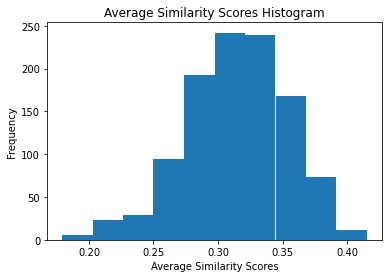

(1080,)
[0.2737 0.3455 0.3142 ... 0.2152 0.2228 0.2228]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the similarity scores from the file
similarity_matrix = np.load("./AI-1k/similarity16.npy")#.reshape(-1, 1)

# Calculate average similarity score for each image/text
# average_scores = np.mean(similarity_matrix, axis=1)

# Create a histogram of the average similarity scores
plt.hist(similarity_matrix, bins=10)

# Set the title and labels
plt.title('Average Similarity Scores Histogram')
plt.xlabel('Average Similarity Scores')
plt.ylabel('Frequency')

# Display the plot
plt.show()

print(similarity_matrix.shape)
print(similarity_matrix)

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit, ShuffleSplit
import numpy as np
import csv
import torch
import clip
from PIL import Image

def prepare_clip_features():
    # Set the device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the CLIP model
    model, preprocess = clip.load("RN101", device=device)
    text_model, text_preprocess = clip.load("ViT-B/16", device=device)

    # Read the CSV file
    csv_filepath = "./AI-1k/AIGC_MOS_Zscore_full.csv"
    image_dir = "./AI-1k/images"
    data_dir='AI-1k'

    image_filenames = []
    prompts = []

    with open(csv_filepath, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        next(csvreader)  # Skip header row
        for row in csvreader:
            image_filenames.append(os.path.join(image_dir, row[0]))
            prompts.append(row[1])

    # Preprocess images and tokenize prompts
    images = torch.stack([preprocess(Image.open(image_filename)).to(device) for image_filename in image_filenames])
    
    # Combine image and text prompts
    combined_prompts = [f"{image_prompt} {text_prompt}" for image_prompt, text_prompt in zip(image_filenames, prompts)]

    # Tokenize combined prompts
    tokens = [clip.tokenize(prompt) for prompt in combined_prompts]
    texts = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=True).to(device)

     # Reshape texts tensor
    # batch_size = len(combined_prompts)
    # max_tokens = max(len(token) for token in tokens)
    # texts = texts.view(batch_size, max_tokens)

    # Compute image and text features
    with torch.no_grad():
        image_features = model.encode_image(images)
        text_features = text_model.encode_text(texts[:, 0, :])
        np.save(os.path.join(data_dir, 'res_clip_image_features.npy'), image_features.cpu().numpy())
        np.save(os.path.join(data_dir, 'res_clip_text_features.npy'), text_features.cpu().numpy())

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features * text_features).sum(dim=-1).cpu().numpy()
        
        print(similarity)
        np.save(os.path.join(data_dir, 'res_similarity.npy'), similarity)

prepare_clip_features()
    


In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit, ShuffleSplit
import numpy as np
import csv
import torch
import clip
from PIL import Image


def prepare_data_splits(data_dir='AGIQA-3k', images_file='AGIQA-3k_scores.csv', output_dir='AGIQA-3k', n_splits=10, test_size=0.2, random_state=42):
    images = pd.read_csv(os.path.join(data_dir, images_file), sep=',')

    # similarity = np.load(os.path.join(data_dir, 'all_similarity.npy'))
    # print(similarity)
    clip_image_features = np.load(os.path.join(data_dir, 'final_clip_features_vit16-mean.npy'))
    print(clip_image_features.shape)
    clip_text_features = np.load(os.path.join(data_dir, 'all_clip16_text_features.npy'))
    print(clip_text_features.shape)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    images.to_csv(os.path.join(output_dir, 'all_image.csv'), sep=',', index=False)

    # ShuffleSplit cross-validation
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, train_size=(1.-test_size), random_state=random_state)

    for split, (train_index, val_index) in enumerate(cv.split(images)):
        images_train_split, images_val_split = images.iloc[train_index], images.iloc[val_index]

        # similarity_train_split, similarity_val_split = similarity[train_index], similarity[val_index]
        clip_image_features_train_split, clip_image_features_val_split = clip_image_features[train_index], clip_image_features[val_index]
        clip_text_features_train_split, clip_text_features_val_split = clip_text_features[train_index], clip_text_features[val_index]

        train_path = os.path.join(output_dir, f"train_comCLIP_image_16_split_{split}.csv")
        val_path = os.path.join(output_dir, f"val_comCLIP_image_16_split_{split}.csv")
        images_train_split.to_csv(train_path, sep=',', index=False)
        images_val_split.to_csv(val_path, sep=',', index=False)

        # np.save(os.path.join(output_dir, f'train_similarity_16_split_{split}.npy'), similarity_train_split)
        np.save(os.path.join(output_dir, f'train_comCLIP_image_features_16_split_{split}.npy'), clip_image_features_train_split)
        np.save(os.path.join(output_dir, f'train_clip_text_features_16_split_{split}.npy'), clip_text_features_train_split)

        # np.save(os.path.join(output_dir, f'val_similarity_16_split_{split}.npy'), similarity_val_split)
        np.save(os.path.join(output_dir, f'val_comCLIP_image_features_16_split_{split}.npy'), clip_image_features_val_split)
        np.save(os.path.join(output_dir, f'val_clip_text_features_16_split_{split}.npy'), clip_text_features_val_split)


# Example usage:
prepare_data_splits()

(2982, 512)
(2982, 512)


In [3]:
import os
import math
import torch
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.model_selection import ShuffleSplit, train_test_split
from scipy.stats import spearmanr, pearsonr

from datasets.AI1k import AI1k_load_data
from models.MetaIQA import MetaIQA

def compute_metrics(
    validation_dataloader: DataLoader,
    model: nn.Module,
    epoch: int,
    criterion: nn.Module,
    fetch_example,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> tuple:
    ground_truth_ratings = []
    predicted_ratings = []
    batch_losses = []
    predictions = []
    preactivations = []
    features = []
    with torch.no_grad():
        for batch_idx, data in enumerate(validation_dataloader):
            inputs, labels = fetch_example(data)

            batch_predictions, batch_preactivations, batch_features = model(*inputs)
            
            predictions.append(batch_predictions.cpu())
            preactivations.append(batch_preactivations.cpu())
            features.append(batch_features.cpu())
            loss = criterion(batch_predictions, labels)
            batch_losses.append(loss.float().cpu())
            ground_truth_ratings.extend(labels.float().cpu().tolist())

    loss = np.mean(batch_losses)
    ground_truth = np.array(ground_truth_ratings)[:,0]
    predictions = np.vstack(predictions)[:,0]
    preactivations = np.vstack(preactivations)[:,0]
    features = np.vstack(features)
    spearman_coefficient = spearmanr(ground_truth, predictions)[0]
    pearson_coefficient = pearsonr(ground_truth, predictions)[0]
    
    print("predictions.shape", predictions.shape)
    print("preactivations.shape", preactivations.shape)
    print("features.shape", features.shape)

    return spearman_coefficient, pearson_coefficient, loss, predictions, preactivations, features

def eval_model(FusionModel, fetch_example, data_dir = os.path.join('AI-1k')):
    model = FusionModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)

    with torch.cuda.device(0):
        criterion = nn.MSELoss()
        model.cuda()

        dataloader_all_eval = AI1k_load_data('all')
        model.eval()

        all_spearman, all_pearson, all_mse, predictions, preactivations, features = compute_metrics(dataloader_all_eval, model, 0, criterion, fetch_example)
        print(f'All Results - PLCC: {all_pearson:.4f}, SROCC: {all_spearman:.4f}, MSE: {all_mse:.4f}')

    # Save ground_truth_ratings and predicted_ratings (optional)
    np.save(os.path.join(data_dir, f'all_MetaIQA_predictions.npy'), predictions)
    np.save(os.path.join(data_dir, f'all_MetaIQA_preactivations.npy'), preactivations)
    np.save(os.path.join(data_dir, f'all_MetaIQA_features.npy'), features)

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        
        # Load the pretrained ResNet18 model
        self.quality_model = MetaIQA('model_IQA/TID2013_KADID10K_IQA_Meta_resnet18.pt')
        self.sig = nn.Sigmoid()
        
    def forward(self, x, similarity_features):
        # Pass the input through the pretrained model 
        quality, quality_features = self.quality_model(x)
        return self.sig(quality), quality, quality_features

def fetch_example(data):
    inputs = data['image']
    similarity = data['similarity']
    print(similarity.shape)
    batch_size = inputs.size()[0]
    labels = data['rating'].view(batch_size, -1) / 5.0
    
    inputs, similarity, labels = Variable(inputs.float().cuda()), Variable(similarity.float().cuda()), Variable(labels.float().cuda())
    return [inputs, similarity], labels

eval_model(FusionModel, fetch_example)


clip_text_features.shape in AI1k.py (1080,)
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])


KeyboardInterrupt: 